# Cycling hire (and private trends) in London and the potential dangers (crime and accidents)
### Data Engineering Capstone Project

#### Project Summary
I would like to answer the following questions:
"Has bicycle use in the capital increased? If so, what impact has there been on accidents involving cyclist and crime to do with bicycles?"

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
  - As I recently took up cycling as a pass-time I thought it would be interesting to assess just how popular cycling is in London
* Step 2: Explore and Assess the Data
  - Gathering data was not that easy but once I had it, I was surprised to find how clean and tidy it was. 
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

Data will be gathered direclty from TFL (Transport for London) via an API. The data in question will be pulled in intially and stored in JSON files (the idea here is to keep a history locally). For this project, only relevant fields will be read into the data tables. However, the JSON files are available in the event a new project or analysis is required. 

Data from TFL, London Met Police and accident data will be used to assess the impact bicycles have had on London. With the use of this data, one can determine if the use of bicycles have increased over time, are bicycle accidents getting worse, is there more bicycle crime etc.

Further analysis can be done against population stats, immigraiton data and bicycle sales to determine if bicycle use has increased and had an impact on TFLs profits. 

#### Describe and Gather Data 
The data will be pulled via an API and static files. 

##### The following sources are being pulled from TFL
- BikePoint data: List all Santander Cycle hire docking stations, including 5 minute real-time bike and docking station status information.
- AccidentStats: Gets all accident details for accidents occuring in the specified year (this will be for the year 2010 to 2018)

##### Casualty data (not in use yet)
    Source: https://data.london.gov.uk/dataset/pedal-cyclist-casualties-killed-and-seriously-injured
- Cycle Casualties: The number of casualties by cyclist over a given period of time broken down by categories

##### Crime data from MetPolice
    Source: https://www.met.police.uk/sd/stats-and-data/met/year-end-crime-statistics/ 
- Crime Data: A text file downloaded from the Met Police site (based on London boroughs)

##### Census data (Cycling)
    Source: https://data.london.gov.uk/dataset/travel-work-bicycle-ward
- Census data: The csv file shows numbers and percentages of people in work aged 16-74 who travel to work by bicycle for all wards in London, from 2001 and 2011 Census. Included percentage point change, and rankings.

##### UK Address data
_(not used at the moment but is a good source of additional data that might shed some light on the types of communities that take up cycling)_

    source: https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-hierarchy-with-classifications-february-2020-lookup-in-the-uk
    Use this source to lookup Borough information based on postcode information (file contains a full list of postcodes)
    Data Dictionary: https://www.arcgis.com/sharing/rest/content/items/b9f02f5935be45f6ad1b6405b0d43f72/info/metadata/metadata.xml?format=default&output=html
- Full address information (NSPCL_FEB20_UK_LU.zip)

In [1]:
# Do all imports and installs here
# Install a pip package in the current Jupyter kernel
# source: https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install tflunifiedapi
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install geopy descartes
#!{sys.executable} -m pip install plotly_express plotly widgetsnbextension~=3.0.0
# !{sys.executable} -m pip install plotly-geo notebook ipywidgets fastprogress

import pandas as pd
from datetime import datetime
import time
import pandas as pd
import numpy as np
import json
import os
import glob
import csv
from pandas.io.json import json_normalize
import requests

# Pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

# source: https://pypi.org/project/geopy/
# For reverse geocoding of coordinates or geocoding of addresses
from geopy.geocoders import Nominatim 


    100% |████████████████████████████████| 92kB 3.6MB/s ta 0:00:011    85% |███████████████████████████▌    | 71kB 3.7MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 12.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for tflunifiedapi ... done
  Stored in directory: /root/.cache/pip/wheels/fd/03/97/354b024108abd188d2e34c0f79ea5544b867e73366900d78a4
Successfully built tflunifiedapi
    100% |████████████████████████████████| 931kB 8.2MB/s eta 0:00:01
    100% |████████████████████████████████| 10.4MB 2.4MB/s eta 0:00:01  7% |██▍                             | 778kB 17.8MB/s eta 0:00:01    15% |█████▏                          | 1.7MB 23.2MB/s eta 0:00:01    26% |████████▌                       | 2.7MB 24.6MB/s eta 0:00:01    39% |████████████▊                   | 4.1MB 33.3MB/s eta 0:00:01    69% |██████████████████████▏         | 7.2MB 32.1MB/s eta 0:00:01
    100% |████████████████████████████████| 14.7MB 2.6MB/s eta 0:00:01   30% |█████████▊                      | 4.

In [2]:
# Instantiate a spark session
spark = SparkSession \
    .builder \
    .appName("dend-Capstone") \
    .getOrCreate()

In [3]:
# Options
pd.set_option('display.max_columns', None)


#### TFL API
Source: https://github.com/dhilmathy/TfL-python-api

Requirements: The installation of tflunifiedapi

In [4]:

from tfl.client import Client
from tfl.api_token import ApiToken

app_id = '17fa'
app_key = 'd2dc5ff3f9c6337d7cb5c2'

token = ApiToken(app_id, app_key)

client = Client(token)
# print (client.AirQuality())
# client.get('https://api.tfl.gov.uk/bikepoint')
# print (client.get_lines(mode="bus")[0])
# print (client.get_lines(line_id="victoria")[0])

##### Load BikePoint and AccidentStats data from TFL 

In [172]:
# Read in AccidentStats data
# Feature to include in future developments:
#   - for each year, check that the data is available before reading it into a json file. For example, 2019 data is not yet available


def get_accidentstats(year):
    with open('./data/accidentstats/accidentStats_' + str(year) + '.json', 'w', encoding='utf-8') as file:
        pl = requests.get("https://api.tfl.gov.uk/AccidentStats/" + str(year) + "/" +
                "?app_id=" + app_id + "&app_key=" + app_key).json()
        jstr = json.dumps(pl, indent=4)
        file.write(jstr + "\n")

    print("accidentStats for "+ str(year) + " written to ./data/accidentstats/accidentStats_" + str(year) + ".json") 

get_accidentstats(2010)
get_accidentstats(2011)
get_accidentstats(2012)    
get_accidentstats(2013)
get_accidentstats(2014)
get_accidentstats(2015)
get_accidentstats(2016)
get_accidentstats(2017)
get_accidentstats(2018)


with open('./data/BikePoint.json', 'w', encoding='utf-8') as file:
    bp = requests.get('https://api.tfl.gov.uk/BikePoint/' +
            '?app_id=' + app_id + '&app_key=' + app_key).json()
    jstr = json.dumps(bp, indent=4)
    file.write(jstr + "\n")

    print("BikePoint file written to ./data/BikPoint.json")

    
# Out of interest, could read in the file as follows:
# aq_url ="https://api.tfl.gov.uk/Place/Meta/PlaceTypes/"
# df = pd.read_json(aq_url)
# df.head(5)

accidentStats for 2010 written to ./data/accidentstats/accidentStats_2010.json
accidentStats for 2011 written to ./data/accidentstats/accidentStats_2011.json
accidentStats for 2012 written to ./data/accidentstats/accidentStats_2012.json
accidentStats for 2013 written to ./data/accidentstats/accidentStats_2013.json
accidentStats for 2014 written to ./data/accidentstats/accidentStats_2014.json
accidentStats for 2015 written to ./data/accidentstats/accidentStats_2015.json
accidentStats for 2016 written to ./data/accidentstats/accidentStats_2016.json
accidentStats for 2017 written to ./data/accidentstats/accidentStats_2017.json
accidentStats for 2018 written to ./data/accidentstats/accidentStats_2018.json
BikePoint file written to ./data/BikPoint.json


In [6]:
# print(pl[0].keys())
# print(pl[0].values())
# pl[0].get['availableKeys'].get['Waterway']

#### Read in BikePoint.json file into a data frame
##### Drop blank columns
##### Reorganise columns
##### Rename Columns

In [4]:
# source: https://www.kaggle.com/jboysen/quick-tutorial-flatten-nested-json-in-pandas

with open("./data/BikePoint.json") as file:
    d = json.load(file)

df_bp = json_normalize(data=d, record_path='additionalProperties'
                         ,meta=['id','commonName','category','key','sourceSystemKey','value','lat','lon','modified']
                        ,errors='ignore'
                        ,record_prefix='_'
                        )
df_bp

df_bp.drop(['_$type','_category','_sourceSystemKey','category','key','sourceSystemKey','value','modified'], axis=1, inplace=True)

#remove underscore from column names
df_bp.columns = df_bp.columns.str.replace('_','')
#Re-Order columns
df_bp = df_bp[['id','commonName','lat','lon','modified']]
#rename columns
df_bp.columns = ['id','general_area','latitude','longitude','dt_modified']


In [5]:
df_bp.sample(n=5)

,id,general_area,latitude,longitude,dt_modified
6044,BikePoints_719,"Victoria Park Road, Hackney Central",51.536424,-0.054162,2020-03-08T19:41:16.957Z
1448,BikePoints_165,"Orsett Terrace, Bayswater",51.517932,-0.183716,2020-03-08T19:38:16.937Z
4410,BikePoints_530,"Newby Place, Poplar",51.508896,-0.012413,2020-03-08T19:05:01.907Z
6990,BikePoints_836,"York Way, Kings Cross",51.541596,-0.125441,2020-03-08T19:15:09.193Z
5868,BikePoints_700,"Battersea Church Road, Battersea",51.476964,-0.174347,2020-03-08T19:14:06.43Z


#### Read In accidentStats data

In [58]:
# get a list of accidentStats files to read in
file_list = os.listdir("./data/accidentstats")
# print(file_list)

# delete csv file if exists
if os.path.exists("./data/accidentstats/accidentstats.csv"):
  os.remove("./data/accidentstats/accidentstats.csv")
  print("removing existing ./data/accidentstats/accidentstats.csv file and creating a new one.")
else:
  print("./data/accidentstats/accidentstats.csv does not exist. Will create a new one.")

# write columns to csv file
print("CSV file created and header column written.")
f = open("./data/accidentstats/accidentstats.csv", "w")
writer = csv.DictWriter(
    f, fieldnames=['index', 'id', 'transport_mode','class','severity','age','ageBand','borough','location','latitude','longitude','date_of_accident'])
writer.writeheader()
f.close()

# Loop through each file and make adjustments. Take the data frame and append it to a file. One file should exist of all accident data
for accidentstats_file in glob.glob("./data/accidentstats/accidentStats*.json"):
#     accidentStats = spark.read.json(accidentstats_file)
    print("Cleaning and appending the following file: " + accidentstats_file)
    with open(accidentstats_file) as file:
        d = json.load(file)

    df_as = json_normalize(data=d, record_path='casualties'
                             ,meta=['id','lat','lon','location','date','severity','borough','age','mode','ageband']
                            ,errors='ignore'
                            ,record_prefix='_'
                            )
    df_as

    df_as.drop(['_$type','_severity','age','mode','ageband'], axis=1, inplace=True)

    #remove underscore from column names
    df_as.columns = df_as.columns.str.replace('_','')
    #Re-Order columns
    df_as = df_as[['id','mode','class','severity','age','ageBand','borough','location','lat','lon','date']]
    #rename columns
    df_as.columns = ['id', 'transport_mode','class','severity','age','ageBand','borough','location','latitude','longitude','date_of_accident']
    
    df_as.to_csv('./data/accidentstats/accidentstats.csv', mode='a', header=False)

print("Clean and Append complete. ./data/accidentstats/accidentstats.csv file created with accidentStats ")
# df_as.sample(n=5)
# df_bp.head(10)

removing existing ./data/accidentstats/accidentstats.csv file and creating a new one.
CSV file created and header column written.
Cleaning and appending the following file: ./data/accidentstats/accidentStats_2016.json
Cleaning and appending the following file: ./data/accidentstats/accidentStats_2018.json
Cleaning and appending the following file: ./data/accidentstats/accidentStats_2015.json
Cleaning and appending the following file: ./data/accidentstats/accidentStats_2014.json
Cleaning and appending the following file: ./data/accidentstats/accidentStats_2012.json
Cleaning and appending the following file: ./data/accidentstats/accidentStats_2011.json
Cleaning and appending the following file: ./data/accidentstats/accidentStats_2013.json
Cleaning and appending the following file: ./data/accidentstats/accidentStats_2017.json
Cleaning and appending the following file: ./data/accidentstats/accidentStats_2010.json
Clean and Append complete. ./data/accidentstats/accidentstats.csv file created

#### Read in london crime data

In [56]:
spdf_crime = spark.read.csv("./data/london_crime_data.csv", header=True)
spdf_crime.createOrReplaceTempView("crime_table")

In [57]:
spdf_crime.printSchema()
spark.sql('''
          SELECT * 
          FROM crime_table 
          LIMIT 3
          '''
          ).show(10,False)

root
 |-- BCU_Code: string (nullable = true)
 |-- BCU_Name: string (nullable = true)
 |-- Financial_Year: string (nullable = true)
 |-- Major_Text: string (nullable = true)
 |-- Minor_Text: string (nullable = true)
 |-- Month_Year: string (nullable = true)
 |-- Number_of_Records: string (nullable = true)
 |-- OCU_Code: string (nullable = true)
 |-- OCU_Name: string (nullable = true)
 |-- Sum_Value: string (nullable = true)
 |-- Type: string (nullable = true)

+--------+-------------------------+--------------+-------------------------+---------------+----------+-----------------+--------+-------------+---------+--------+
|BCU_Code|BCU_Name                 |Financial_Year|Major_Text               |Minor_Text     |Month_Year|Number_of_Records|OCU_Code|OCU_Name     |Sum_Value|Type    |
+--------+-------------------------+--------------+-------------------------+---------------+----------+-----------------+--------+-------------+---------+--------+
|CE      |Central East Command Unit|fy10-

#### Read in Census data

In [55]:
df_census = pd.read_csv("./data/travel-work-bicycle-census-2001-2011-ward.csv") 
print(df_census.dtypes)
df_census.head(5)

Ward                               object
Old_ward_code                      object
Ward_name                          object
Borough_name                       object
2001_All_aged_16_74_in_work        object
2001_Travel_by_bicycle              int64
2001_percent_travel_by_bicycle    float64
2011_All_aged_16_74_in_work        object
2011_Travel_by_bicycle             object
2011_percent_travel_by_bicycle    float64
Percentage_point_change           float64
dtype: object


,Ward,Old_ward_code,Ward_name,Borough_name,2001_All_aged_16_74_in_work,2001_Travel_by_bicycle,2001_percent_travel_by_bicycle,2011_All_aged_16_74_in_work,2011_Travel_by_bicycle,2011_percent_travel_by_bicycle,Percentage_point_change
0,E09000001,00AA,City of London,City of London,"4,247",73,1.7,"4,747",252,5.3,3.6
1,E05000026,00ABFX,Abbey,Barking and Dagenham,"4,124",47,1.1,"5,489",44,0.8,-0.3
2,E05000027,00ABFY,Alibon,Barking and Dagenham,"3,633",69,1.9,"4,214",43,1.0,-0.9
3,E05000028,00ABFZ,Becontree,Barking and Dagenham,"4,339",82,1.9,"4,674",77,1.6,-0.2
4,E05000029,00ABGA,Chadwell Heath,Barking and Dagenham,"3,566",30,0.8,"3,916",46,1.2,0.3


#### Read in Address data

In [52]:
# Read in Zip file and summarise data with the aim of filtering and keeping only London data
# df_add = pd.read_csv('./unused_data/NSPCL_FEB20_UK_LU.zip', compression='zip', header=0, sep=',', quotechar='"', encoding = "ISO-8859-1", 
#                      dtype={"pcd7": object, "pcd8": object,
#                     "pcds":object, "dointr":object, "dointr":float, "doterm":float, "usertype":float, "oseast1m":float,"osnrth1m":float, "oa11cd":object, 
#                     "oac11cd":object, "oac11nm":object, "wz11cd":object, "wzc11cd":object, "wzc11nm":object, "lsoa11cd":object, "lsoa11nm":object, 
#                     "msoa11cd":object, "msoa11nm":object, "soac11cd":object, "soac11nm":object, "ladcd":object, "ladnm":object, "ladnmw":object, "laccd":object, "lacnm":object}
#                     )


# Removed this portion of code as it was not used in the end. I also had to remove the file (as well as others) because I was unable to submit my project. 
# The error I received was #...file size limit".

In [53]:
# df_add.sample(n=3)

,pcd7,pcd8,pcds,dointr,doterm,usertype,oseast1m,osnrth1m,oa11cd,oac11cd,oac11nm,wz11cd,wzc11cd,wzc11nm,lsoa11cd,lsoa11nm,msoa11cd,msoa11nm,soac11cd,soac11nm,ladcd,ladnm,ladnmw,laccd,lacnm
789055,EH458QE,EH45 8QE,EH45 8QE,198001.0,NaN,0.0,325252.0,640945.0,S00095446,5B3,Self-sufficient retirement,S34002398,A2,Market squares,S01012255,Peebles - N - Eastgate,S02002293,Peebles North,5A,Ageing urban communities,S12000026,Scottish Borders,NaN,3C1,Scottish Countryside
535401,CT214SA,CT21 4SA,CT21 4SA,198704.0,198812.0,1.0,623100.0,135900.0,E00124385,2C1,Migrant families,E33045422,C5,Professional home-workers in outer suburbs,E01033215,Shepway 014D,E02006879,Shepway 014,1A,Cosmopolitan student neighbourhoods,E07000112,Folkestone and Hythe,NaN,3B2,Seaside Living
930225,GL542GT,GL54 2GT,GL54 2GT,201411.0,NaN,0.0,420790.0,219263.0,E00112909,1B1,Rural life,E33049756,F3,Rural with mining or quarrying,E01022214,Cotswold 003C,E02004617,Cotswold 003,2B,Prospering countryside life,E07000079,Cotswold,NaN,3A1,Older Farming Communities


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

##### Joining the data


#### Cleaning Steps
Document steps necessary to clean the data

#### Explore and Clean BikePoint data

In [10]:
#Basics
print(df_bp.dtypes)
print()
print(df_bp.describe())
print()
print(df_bp.shape)

id               object
general_area     object
latitude        float64
longitude       float64
dt_modified      object
dtype: object

          latitude    longitude
count  7047.000000  7047.000000
mean     51.506027    -0.128443
std       0.020130     0.054661
min      51.454752    -0.236769
25%      51.493146    -0.171681
50%      51.509301    -0.130110
75%      51.520962    -0.093051
max      51.549369    -0.002275

(7047, 5)


In [11]:
df_bp.head(n=3)

,id,general_area,latitude,longitude,dt_modified
0,BikePoints_1,"River Street , Clerkenwell",51.529163,-0.10997,2020-03-08T18:28:54.027Z
1,BikePoints_1,"River Street , Clerkenwell",51.529163,-0.10997,2020-03-08T18:28:54.027Z
2,BikePoints_1,"River Street , Clerkenwell",51.529163,-0.10997,2020-03-08T18:28:54.027Z


In [12]:
# Drop duplicates
df_bp.drop_duplicates(['id', 'latitude','longitude'], inplace=True)
print('Duplicates removed from main dataframe: ', df_bp.shape)
print()
df_bp.head(5)


Duplicates removed from main dataframe:  (783, 5)



,id,general_area,latitude,longitude,dt_modified
0,BikePoints_1,"River Street , Clerkenwell",51.529163,-0.109970,2020-03-08T18:28:54.027Z
9,BikePoints_2,"Phillimore Gardens, Kensington",51.499606,-0.197574,2020-03-08T19:10:07.153Z
18,BikePoints_3,"Christopher Street, Liverpool Street",51.521283,-0.084605,2020-03-08T19:28:13.94Z
27,BikePoints_4,"St. Chad's Street, King's Cross",51.530059,-0.120973,2020-03-08T19:26:13.493Z
36,BikePoints_5,"Sedding Street, Sloane Square",51.493130,-0.156876,2020-03-08T19:41:16.957Z


In [163]:
# df_bp['latitude'] == ['51.523677']
# df_bp.query('latitude == 51.523677 ')

,id,general_area,latitude,longitude,dt_modified,coordinates,address


In [198]:
# Using Latitude and Longitude - pull out the borough and ward information. 
# Source: https://towardsdatascience.com/reverse-geocoding-in-python-a915acf29eb6
import time
start_time = time.time()
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="reverse_Geocoder", timeout=60)
rgeocode = RateLimiter(geolocator.reverse, min_delay_seconds=1.1, max_retries=5, error_wait_seconds=2.0, swallow_exceptions=True)

# Example to test if it works
# df_bp['address'] = df_bp.apply(lambda x: rgeocode((x['latitude'],x['longitude']),language='en', exactly_one=True).address, axis=1)
# location = rgeocode((df_bp.coordinates[4555]), language='en', exactly_one=True)
# location = geolocator.reverse(df_temp.coordinates[6084])
# print(location.raw)
# print()
# print(location.address)

print()
# Sort data set
df_bp.sort_values(by=['id'], inplace=True)
# Create a new column comibing latitude and longitude for the purpose of reverse geocoding
df_bp['coordinates'] = df_bp['latitude'].map(str) + ',' + df_bp['longitude'].map(str)
print('Coordinates column added to dataframe to help with Borough lookup: ',df_bp.shape)
#Create a dataframe to hold address information
# df_address = df_bp[['id','coordinates']].copy()
print()

# Reverse lookup addresses given coordinates (and progress bar)
# source: https://gis.stackexchange.com/questions/331144/bulk-reverse-geocoding-with-geopy-using-built-in-rate-limiter
for index, row in df_bp.iterrows(): 
    location = rgeocode((row['coordinates']), language='en', exactly_one=True)
#     df_bp['address'] = location.address
    df_bp.at[index,'address'] = location.address
    print("Retrieving borough information for: {} - {}".format(index, row['id']))
    if index==90:
        print()
        print("Test to see if the data is loading correctly...")
        print(df_bp.head(3))
        print()
print()


time = time.time() - start_time
day = time // (24 * 3600)
time = time % (24 * 3600)
hour = time // 3600
time %= 3600
minutes = time // 60
time %= 60
seconds = time
print("The time it has taken to get address data -> %d:%d:%d" % (hour, minutes, seconds))
print()
print('Pulling address information is complete')



Coordinates column added to dataframe to help with Borough lookup:  (783, 7)

Retrieving borough information for: 0 - BikePoints_1
Retrieving borough information for: 81 - BikePoints_10
Retrieving borough information for: 873 - BikePoints_100
Retrieving borough information for: 882 - BikePoints_101
Retrieving borough information for: 891 - BikePoints_102
Retrieving borough information for: 900 - BikePoints_103
Retrieving borough information for: 909 - BikePoints_104
Retrieving borough information for: 918 - BikePoints_105
Retrieving borough information for: 927 - BikePoints_106
Retrieving borough information for: 936 - BikePoints_107
Retrieving borough information for: 945 - BikePoints_108
Retrieving borough information for: 954 - BikePoints_109
Retrieving borough information for: 90 - BikePoints_11

Test to see if the data is loading correctly...
                 id                 general_area   latitude  longitude  \
0      BikePoints_1   River Street , Clerkenwell  51.529163  -0.1

In [199]:
# Write out the data to a csv file to prevent having to query the API again given that there are limits
# Uncomment the below lines if you want to update the file - I have commented it out to prevent me overwriting the file and having to query the API again
# df_bp.to_csv('./data/bikepoint_data', index=False)
# print("BikePoint with address information written to CSV")
df_bp.head(3)

BikePoint with address information written to CSV


,id,general_area,latitude,longitude,dt_modified,coordinates,address
0,BikePoints_1,"River Street , Clerkenwell",51.529163,-0.109970,2020-03-08T18:28:54.027Z,"51.529163,-0.10997","River Street, Angel, Pentonville, London Borou..."
81,BikePoints_10,"Park Street, Bankside",51.505974,-0.092754,2020-03-08T14:36:26.113Z,"51.505974,-0.092754","Roman Southwark, Bowling Green Place, Bermonds..."
873,BikePoints_100,"Albert Embankment, Vauxhall",51.490435,-0.122806,2020-03-08T19:30:13.36Z,"51.490435,-0.122806","Albert Embankment, Vauxhall, London Borough of..."


In [53]:
# Get the Postcode from the address field for BikePoint data
df_bp = pd.read_csv('./data/bikepoint_data')
df_bp.sample(n=3)

,id,general_area,latitude,longitude,dt_modified,coordinates,address,borough
547,BikePoints_63,"Murray Grove , Hoxton",51.530890,-0.089782,2020-03-08T18:43:56.877Z,"51.53089,-0.089782","Marie Lloyd House, Cavendish Street, Hoxton, L...",Hackney
645,BikePoints_719,"Victoria Park Road, Hackney Central",51.536424,-0.054162,2020-03-08T19:41:16.957Z,"51.536424,-0.054162","53, Victoria Park Road, London Borough of Hack...",Hackney
46,BikePoints_141,"Chapel Place, Marylebone",51.515308,-0.147203,2020-03-08T19:25:13.407Z,"51.515308,-0.147203","St. Peter's Church Vere Street, Chapel Place, ...",Westminster


In [181]:
# df_bp['address'].str.split(',').str[-2]

In [15]:
#Unique BikePoints
df_bp = pd.read_csv('./data/bikepoint_data')
print("Number of unique bike points: " , df_bp['id'].nunique())
print()

# Are there any missing ids?
print("Number of missing values: ")
print(df_bp.isnull().sum(axis=0))

print()

Number of unique bike points:  783

Number of missing values: 
id              0
general_area    0
latitude        0
longitude       0
dt_modified     0
coordinates     0
address         0
borough         0
dtype: int64



In [16]:
df_bp.sample(n=3)


,id,general_area,latitude,longitude,dt_modified,coordinates,address,borough
273,BikePoints_358,"High Holborn , Covent Garden",51.516226,-0.124826,2020-03-08T19:29:14.09Z,"51.516226,-0.124826","Travelodge, West Central Street, Holborn, St G...",Camden
89,BikePoints_182,"Bell Street , Marylebone",51.522029,-0.165842,2020-03-08T19:07:04.163Z,"51.522029,-0.165842","95, Bell Street, St. John's Wood, City of West...",Westminster
234,BikePoints_319,"Baldwin Street, St. Luke's",51.527025,-0.088542,2020-03-08T19:12:07.273Z,"51.527025,-0.088542","Barclays, Baldwin Street, Saint Luke's, London...",Islington


/opt/conda/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


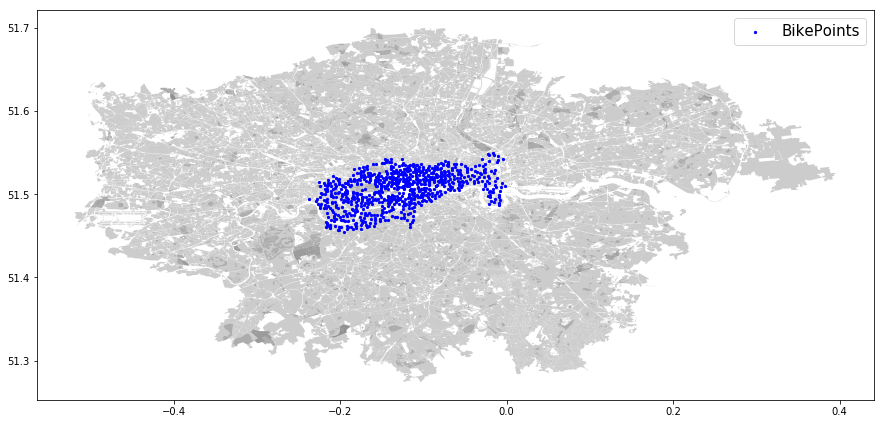

In [163]:
# source: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
import matplotlib.pyplot as plt
# import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = (30,30)
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

# source of Map data: http://download.geofabrik.de/europe/great-britain/england/greater-london-latest-free.shp.zip
map = gpd.read_file('./additional_files/map/greater_london_landuse.shp')
# fig, ax = plt.subplots(figsize = (15,15))
# map.plot(ax=ax)

crs = {'init': 'epsg:4326'}

#fix this code as this logic is deprecated
geometry = [Point(xy) for xy in zip( df_bp["longitude"],df_bp["latitude"])]
# geometry[:3]
geo_df = gpd.GeoDataFrame(df_bp,
                          crs=crs,
                          geometry=geometry)
# geo_df.head()

fig, ax= plt.subplots(figsize = (15,15))
map.plot(ax=ax, alpha=0.4, color='grey')
#Check the source page for how you can plot two sets of data points on the map with differing colours etc.
geo_df.plot(ax=ax, markersize=5, color='blue', marker='o', label='BikePoints')
plt.legend(prop={'size':15})
plt.show()

In [ ]:
df_bp.head(3)

#### Explore and Clean AccidentStats data

In [59]:
# Read in csv file using pyspark
spdf_accstats = spark.read.csv("./data/accidentstats/accidentstats.csv", header=True)

# spdf_accstats.take(5)
spdf_accstats.printSchema()

spdf_accstats.take(3)

root
 |-- index: string (nullable = true)
 |-- id: string (nullable = true)
 |-- transport_mode: string (nullable = true)
 |-- class: string (nullable = true)
 |-- severity: string (nullable = true)
 |-- age: string (nullable = true)
 |-- ageBand: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- location: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- date_of_accident: string (nullable = true)



[Row(index='0', id='269566', transport_mode='PedalCycle', class='Driver', severity='Slight', age='31.0', ageBand='Adult', borough='City of Westminster', location='Whitehall junction with Great Scotland Yard', latitude='51.505949', longitude='-0.127106', date_of_accident='2016-06-16T23:14:00Z'),
 Row(index='1', id='269567', transport_mode='Car', class='Driver', severity='Slight', age='53.0', ageBand='Adult', borough='City of Westminster', location='Bayswater Road junction with Caroline Close', latitude='51.510148', longitude='-0.188325', date_of_accident='2016-06-16T09:48:00Z'),
 Row(index='2', id='269567', transport_mode='BusOrCoach', class='Driver', severity='Slight', age='55.0', ageBand='Adult', borough='City of Westminster', location='Bayswater Road junction with Caroline Close', latitude='51.510148', longitude='-0.188325', date_of_accident='2016-06-16T09:48:00Z')]

In [60]:
# Change Latitude, Longitude columns to float type and change date_of_accident to datetime type
from pyspark.sql.functions import col

cols = ['latitude','longitude']

for col_name in cols:
    spdf_accstats = spdf_accstats.withColumn(col_name, col(col_name).cast('float'))
    
spdf_accstats = spdf_accstats.withColumn('date_of_accident', col('date_of_accident').cast('timestamp'))

spdf_accstats.printSchema()
spdf_accstats.show(5)

root
 |-- index: string (nullable = true)
 |-- id: string (nullable = true)
 |-- transport_mode: string (nullable = true)
 |-- class: string (nullable = true)
 |-- severity: string (nullable = true)
 |-- age: string (nullable = true)
 |-- ageBand: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- location: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- date_of_accident: timestamp (nullable = true)

+-----+------+-----------------+------+--------+----+-------+-------------------+--------------------+---------+---------+-------------------+
|index|    id|   transport_mode| class|severity| age|ageBand|            borough|            location| latitude|longitude|   date_of_accident|
+-----+------+-----------------+------+--------+----+-------+-------------------+--------------------+---------+---------+-------------------+
|    0|269566|       PedalCycle|Driver|  Slight|31.0|  Adult|City of Westminster|Whiteha

In [61]:
# Transport Mode
# spdf_accstats.select("transport_mode").dropDuplicates().sort("transport_mode").show()
# Create a temp view to query accident data 
spdf_accstats.createOrReplaceTempView("accidentStats_table")
print('Total rows in AccidentStats from TFL')
spark.sql('''
          SELECT transport_mode, count(*) as cnt
          FROM accidentStats_table 
          group by 1
          order by 1
          '''
          ).show()

Total rows in AccidentStats from TFL
+-----------------+------+
|   transport_mode|   cnt|
+-----------------+------+
|       BusOrCoach| 27274|
|              Car|211786|
|     GoodsVehicle| 11008|
|     OtherVehicle|  2300|
|       PedalCycle| 82120|
|       Pedestrian|100486|
|PoweredTwoWheeler| 89592|
|             Taxi| 12474|
+-----------------+------+



In [62]:
# Keep only rows where transport_mode = "PedalCycle"

spdf_accstats = spdf_accstats.where(spdf_accstats.transport_mode == "PedalCycle")
spdf_accstats.select("transport_mode").dropDuplicates().sort("transport_mode").show()
spdf_accstats.printSchema()

+--------------+
|transport_mode|
+--------------+
|    PedalCycle|
+--------------+

root
 |-- index: string (nullable = true)
 |-- id: string (nullable = true)
 |-- transport_mode: string (nullable = true)
 |-- class: string (nullable = true)
 |-- severity: string (nullable = true)
 |-- age: string (nullable = true)
 |-- ageBand: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- location: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- date_of_accident: timestamp (nullable = true)



In [63]:
spdf_accstats.show(3, False)

+-----+------+--------------+------+--------+----+-------+-------------------+-------------------------------------------+---------+---------+-------------------+
|index|id    |transport_mode|class |severity|age |ageBand|borough            |location                                   |latitude |longitude|date_of_accident   |
+-----+------+--------------+------+--------+----+-------+-------------------+-------------------------------------------+---------+---------+-------------------+
|0    |269566|PedalCycle    |Driver|Slight  |31.0|Adult  |City of Westminster|Whitehall junction with Great Scotland Yard|51.505947|-0.127106|2016-06-16 23:14:00|
|11   |269576|PedalCycle    |Driver|Slight  |21.0|Adult  |City of Westminster|Regent Street junction with Cavendish Place|51.517353|-0.142925|2016-06-22 00:56:00|
|13   |269578|PedalCycle    |Driver|Slight  |20.0|Adult  |City of Westminster|Edgware Road junction with Aberdeen Place  |51.524628|-0.176938|2016-06-21 21:04:00|
+-----+------+--------

In [64]:
# Create a temp view to query accident data 
spdf_accstats.createOrReplaceTempView("accidentStats_table")

In [65]:
# List of accidents by borough
spark.sql('''
          SELECT transport_mode, borough, count(*) as accident_cnt
          FROM accidentStats_table 
          group by 1,2
          order by count(*) desc
          '''
          ).show()

+--------------+--------------------+------------+
|transport_mode|             borough|accident_cnt|
+--------------+--------------------+------------+
|    PedalCycle| City of Westminster|        7076|
|    PedalCycle|             Lambeth|        5690|
|    PedalCycle|           Southwark|        5298|
|    PedalCycle|          Wandsworth|        5004|
|    PedalCycle|           Islington|        4662|
|    PedalCycle|       Tower Hamlets|        4508|
|    PedalCycle|              Camden|        4498|
|    PedalCycle|             Hackney|        4496|
|    PedalCycle|Kensington and Ch...|        3178|
|    PedalCycle|Hammersmith and F...|        3094|
|    PedalCycle|            Lewisham|        2662|
|    PedalCycle|Richmond upon Thames|        2398|
|    PedalCycle|      City of London|        2394|
|    PedalCycle|            Hounslow|        2112|
|    PedalCycle|            Haringey|        2110|
|    PedalCycle|              Ealing|        2056|
|    PedalCycle|      Waltham F

In [66]:
# Combine BikePoints and AccidentStats into one dataframe to plot against each other on a map


# Prepare both dataframes
# Accident Stats data
df_accstats = spdf_accstats.select("latitude", "longitude").toPandas()
df_acc_data = df_accstats.copy()
df_acc_data['label'] = 'accidents'
df_acc_data = df_acc_data[['latitude','longitude','label']].copy()

# BikePoint data
df_bp_data = df_bp.copy()
df_bp_data["label"] = 'bikepoint'
df_bp_data = df_bp_data[['latitude','longitude', 'label']].copy()

# Append data to create one large dataframe
pd_map_data = pd.concat([df_bp_data, df_acc_data], axis=0)

print("Number of labels in appended dataframe: " , pd_map_data['label'].nunique())
print()

pd_map_data.sample(n=2)

Number of labels in appended dataframe:  2



,latitude,longitude,label
32100,51.506207,-0.224649,accidents
7617,51.347736,-0.147780,accidents


/opt/conda/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Plotting points on the map... takes a while...


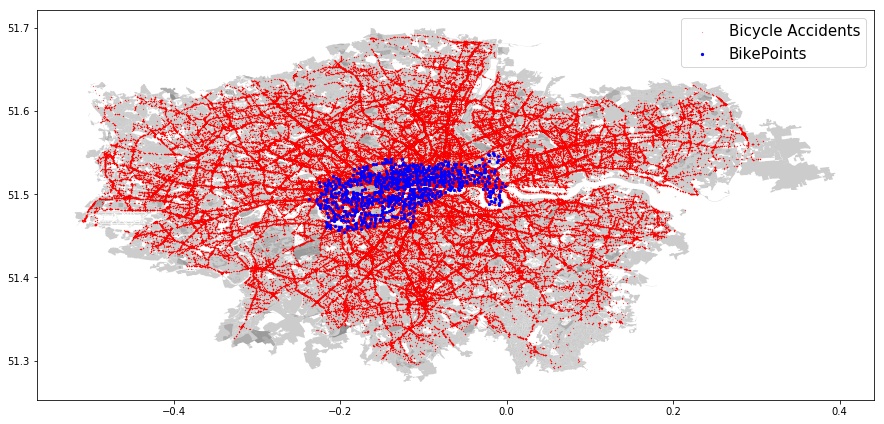

In [201]:
# Make sure you have created the df_bp dataframe and plotted the BikePoint data against the map (see code above)
%matplotlib inline

# source of Map data: http://download.geofabrik.de/europe/great-britain/england/greater-london-latest-free.shp.zip
map = gpd.read_file('./additional_files/map/greater_london_landuse.shp')
crs = {'init': 'epsg:4326'}

#fix this code as this logic is deprecated
geometry = [Point(xy) for xy in zip( pd_map_data["longitude"],pd_map_data["latitude"])]
# geometry[:3]

geo_df = gpd.GeoDataFrame(pd_map_data,
                           crs=crs,
                           geometry=geometry)

geo_df.sample(n=3)

fig, ax= plt.subplots(figsize = (15,15))
map.plot(ax=ax, alpha=0.4, color='grey')

#Check the source page for how you can plot two sets of data points on the map with differing colours etc.
print('Plotting points on the map... takes a while...')
geo_df[geo_df['label'] == 'accidents'].plot(ax=ax, markersize=0.1, color='red', marker='.', label='Bicycle Accidents')
geo_df[geo_df['label'] == 'bikepoint'].plot(ax=ax, markersize=5, color='blue', marker='o', label='BikePoints')


plt.legend(prop={'size':15})

print("Bicycle Accidents over the last 10 years or so and Bicycle Hire points in London"))
plt.show()

#### Explore and Clean London Crime data

In [67]:
spdf_crime.printSchema()

temp_sp = spdf_crime
spdf_crime.take(3)

root
 |-- BCU_Code: string (nullable = true)
 |-- BCU_Name: string (nullable = true)
 |-- Financial_Year: string (nullable = true)
 |-- Major_Text: string (nullable = true)
 |-- Minor_Text: string (nullable = true)
 |-- Month_Year: string (nullable = true)
 |-- Number_of_Records: string (nullable = true)
 |-- OCU_Code: string (nullable = true)
 |-- OCU_Name: string (nullable = true)
 |-- Sum_Value: string (nullable = true)
 |-- Type: string (nullable = true)



[Row(BCU_Code='CE', BCU_Name='Central East Command Unit', Financial_Year='fy10-11', Major_Text='Arson and Criminal Damage', Minor_Text='Arson', Month_Year='4/1/2010', Number_of_Records='1', OCU_Code='GD', OCU_Name='Hackney', Sum_Value='14', Type='Offences'),
 Row(BCU_Code='CE', BCU_Name='Central East Command Unit', Financial_Year='fy10-11', Major_Text='Arson and Criminal Damage', Minor_Text='Criminal Damage', Month_Year='4/1/2010', Number_of_Records='1', OCU_Code='GD', OCU_Name='Hackney', Sum_Value='210', Type='Offences'),
 Row(BCU_Code='CE', BCU_Name='Central East Command Unit', Financial_Year='fy10-11', Major_Text='Arson and Criminal Damage', Minor_Text='Arson', Month_Year='4/1/2010', Number_of_Records='1', OCU_Code='HT', OCU_Name='Tower Hamlets', Sum_Value='10', Type='Offences')]

In [68]:
# Rename OCU_Name, OCU_Code, Major_Text, Minor_Text columns

spdf_crime = spdf_crime.withColumnRenamed("OCU_Name", "Borough")
spdf_crime = spdf_crime.withColumnRenamed("OCU_Code", "Borough_Code")
spdf_crime = spdf_crime.withColumnRenamed("Major_Text", "Major_Crime_Category")
spdf_crime = spdf_crime.withColumnRenamed("Minor_Text", "Minor_Crime_Category")

spdf_crime.printSchema()

root
 |-- BCU_Code: string (nullable = true)
 |-- BCU_Name: string (nullable = true)
 |-- Financial_Year: string (nullable = true)
 |-- Major_Crime_Category: string (nullable = true)
 |-- Minor_Crime_Category: string (nullable = true)
 |-- Month_Year: string (nullable = true)
 |-- Number_of_Records: string (nullable = true)
 |-- Borough_Code: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Sum_Value: string (nullable = true)
 |-- Type: string (nullable = true)



In [69]:
# Extract Year and Month values (column Month_Year is just that even though it has a value for day. The value for day is always 1)
from pyspark.sql import functions as F

spdf_crime = spdf_crime.withColumn('Month', F.split(spdf_crime['Month_Year'], '/')[0])
spdf_crime = spdf_crime.withColumn('Year', F.split(spdf_crime['Month_Year'], '/')[2])

spdf_crime.printSchema()


root
 |-- BCU_Code: string (nullable = true)
 |-- BCU_Name: string (nullable = true)
 |-- Financial_Year: string (nullable = true)
 |-- Major_Crime_Category: string (nullable = true)
 |-- Minor_Crime_Category: string (nullable = true)
 |-- Month_Year: string (nullable = true)
 |-- Number_of_Records: string (nullable = true)
 |-- Borough_Code: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Sum_Value: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: string (nullable = true)



In [70]:
# spdf_crime.createOrReplaceTempView("crime_table")

# spark.sql('''
#             select distinct OCU_Name as Borough
#             from crime_table
#             order by 1 asc
#         ''').show()

In [71]:
# Get a list of crimes
spdf_crime.select("Minor_Crime_Category").dropDuplicates().sort("Minor_Crime_Category").show(truncate=False, n=15)

# Keep only those crimes where minor_text = "Bicycle Theft"
spdf_crime = spdf_crime.where(spdf_crime.Minor_Crime_Category == "Bicycle Theft")
spdf_crime.select("Minor_Crime_Category").dropDuplicates().sort("Minor_Crime_Category").show(truncate=False, n=15)


+------------------------------------------------------------+
|Minor_Crime_Category                                        |
+------------------------------------------------------------+
|Absconding from Lawful Custody                              |
|Aggravated Vehicle Taking                                   |
|Aiding Suicide                                              |
|Arson                                                       |
|Bail Offences                                               |
|Bicycle Theft                                               |
|Bigamy                                                      |
|Burglary - Business and Community                           |
|Burglary - Residential                                      |
|Concealing an Infant Death Close to Birth                   |
|Criminal Damage                                             |
|Dangerous Driving                                           |
|Disclosure, Obstruction, False or Misleading Statement

In [72]:
#Create a temp view
spdf_crime.createOrReplaceTempView("crime_table")
spdf_crime.printSchema()
spark.sql('''
            select *
            from crime_table
            limit 2
        ''').show()

root
 |-- BCU_Code: string (nullable = true)
 |-- BCU_Name: string (nullable = true)
 |-- Financial_Year: string (nullable = true)
 |-- Major_Crime_Category: string (nullable = true)
 |-- Minor_Crime_Category: string (nullable = true)
 |-- Month_Year: string (nullable = true)
 |-- Number_of_Records: string (nullable = true)
 |-- Borough_Code: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Sum_Value: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: string (nullable = true)

+--------+--------------------+--------------+--------------------+--------------------+----------+-----------------+------------+-------------+---------+--------+-----+----+
|BCU_Code|            BCU_Name|Financial_Year|Major_Crime_Category|Minor_Crime_Category|Month_Year|Number_of_Records|Borough_Code|      Borough|Sum_Value|    Type|Month|Year|
+--------+--------------------+--------------+--------------------+--------------------+--

In [73]:
spark.sql('''
            select Major_Crime_Category, Minor_Crime_Category, Financial_Year, sum(Sum_Value) as total_crimes
            from crime_table
            where Type = "Offences"
            group by 1,2,3
            order by Financial_Year
        ''').show()

spark.sql('''
            select *
            from crime_table
            where Borough = "City of Westminster"
            limit 5
        ''').show(5, False)

+--------------------+--------------------+--------------+------------+
|Major_Crime_Category|Minor_Crime_Category|Financial_Year|total_crimes|
+--------------------+--------------------+--------------+------------+
|               Theft|       Bicycle Theft|       fy10-11|     22061.0|
|               Theft|       Bicycle Theft|       fy11-12|     23133.0|
|               Theft|       Bicycle Theft|       fy12-13|     20731.0|
|               Theft|       Bicycle Theft|       fy13-14|     18897.0|
|               Theft|       Bicycle Theft|       fy14-15|     17288.0|
|               Theft|       Bicycle Theft|       fy15-16|     16598.0|
|               Theft|       Bicycle Theft|       fy16-17|     18872.0|
|               Theft|       Bicycle Theft|       fy17-18|     20790.0|
|               Theft|       Bicycle Theft|       fy18-19|     20337.0|
+--------------------+--------------------+--------------+------------+

+--------+--------+--------------+--------------------+--------

In [74]:
#Get bicycle thefts per year
spark.sql('''
            select year, Minor_Crime_Category, Borough, sum(sum_value) as total_bicycle_thefts
            from crime_table
            group by 1,2,3
            order by 4 desc
        ''').show()


+----+--------------------+-------------+--------------------+
|year|Minor_Crime_Category|      Borough|total_bicycle_thefts|
+----+--------------------+-------------+--------------------+
|2011|       Bicycle Theft|  Westminster|              1794.0|
|2017|       Bicycle Theft|      Hackney|              1726.0|
|2012|       Bicycle Theft|  Westminster|              1721.0|
|2017|       Bicycle Theft|Tower Hamlets|              1696.0|
|2018|       Bicycle Theft|      Hackney|              1695.0|
|2011|       Bicycle Theft|      Hackney|              1640.0|
|2017|       Bicycle Theft|    Southwark|              1629.0|
|2012|       Bicycle Theft|      Hackney|              1626.0|
|2012|       Bicycle Theft|Tower Hamlets|              1609.0|
|2010|       Bicycle Theft|  Westminster|              1558.0|
|2011|       Bicycle Theft|    Islington|              1497.0|
|2011|       Bicycle Theft|    Southwark|              1479.0|
|2016|       Bicycle Theft|      Hackney|              

In [75]:
# drop unecessary columns
spdf_crime=spdf_crime.drop(col("Financial_Year"))
spdf_crime=spdf_crime.drop(col("Month_Year"))
spdf_crime=spdf_crime.drop(col("Borough_Code"))
spdf_crime.printSchema()

root
 |-- BCU_Code: string (nullable = true)
 |-- BCU_Name: string (nullable = true)
 |-- Major_Crime_Category: string (nullable = true)
 |-- Minor_Crime_Category: string (nullable = true)
 |-- Number_of_Records: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Sum_Value: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: string (nullable = true)



#### Explore and Clean Census data

In [238]:
df_temp=df_census.copy()

df_census.sample(n=3)
print(df_census.dtypes)

Ward_code                         object 
Old_ward_code                     object 
Ward                              object 
Borough                           object 
2001_All_aged_16_74_in_work       int64  
2001_Travel_by_bicycle            int64  
2001_percent_travel_by_bicycle    float64
2011_All_aged_16_74_in_work       int64  
2011_Travel_by_bicycle            int64  
2011_percent_travel_by_bicycle    float64
Percentage_point_change           float64
dtype: object


In [240]:
# Remove commas from numbers
df_census['2001_All_aged_16_74_in_work'] = df_census['2001_All_aged_16_74_in_work'].str.replace(',', '').astype(int)
df_census['2001_Travel_by_bicycle'] = df_census['2001_Travel_by_bicycle'].str.replace(',', '').astype(int)
df_census['2011_All_aged_16_74_in_work'] = df_census['2011_All_aged_16_74_in_work'].str.replace(',', '').astype(int)
df_census['2011_Travel_by_bicycle'] = df_census['2011_Travel_by_bicycle'].str.replace(',', '').astype(int)
print(df_census.dtypes)
df_census.sample(n=3)

Ward_code                         object 
Old_ward_code                     object 
Ward                              object 
Borough                           object 
2001_All_aged_16_74_in_work       int64  
2001_Travel_by_bicycle            int64  
2001_percent_travel_by_bicycle    float64
2011_All_aged_16_74_in_work       int64  
2011_Travel_by_bicycle            int64  
2011_percent_travel_by_bicycle    float64
Percentage_point_change           float64
dtype: object


,Ward_code,Old_ward_code,Ward,Borough,2001_All_aged_16_74_in_work,2001_Travel_by_bicycle,2001_percent_travel_by_bicycle,2011_All_aged_16_74_in_work,2011_Travel_by_bicycle,2011_percent_travel_by_bicycle,Percentage_point_change
index,,,,,,,,,,,
123,E05000148,00AHGG,Bensham Manor,Croydon,7375,103,1.4,7482,97,1.3,-0.1
179,E05000204,00AKGY,Lower Edmonton,Enfield,5193,62,1.2,6188,73,1.2,0.0
531,E05000556,00BFGD,Beddington South,Sutton,4419,57,1.3,4896,76,1.6,0.3


In [242]:
df_census.reset_index(inplace=True)
df_census.set_index('index', inplace=True)
# print(df_temp.dtypes)
df_census.head(3)

,Ward_code,Old_ward_code,Ward,Borough,2001_All_aged_16_74_in_work,2001_Travel_by_bicycle,2001_percent_travel_by_bicycle,2011_All_aged_16_74_in_work,2011_Travel_by_bicycle,2011_percent_travel_by_bicycle,Percentage_point_change
index,,,,,,,,,,,
0,E09000001,00AA,City of London,City of London,4247,73,1.7,4747,252,5.3,3.6
1,E05000026,00ABFX,Abbey,Barking and Dagenham,4124,47,1.1,5489,44,0.8,-0.3
2,E05000027,00ABFY,Alibon,Barking and Dagenham,3633,69,1.9,4214,43,1.0,-0.9


In [243]:
df_census.describe()

,2001_All_aged_16_74_in_work,2001_Travel_by_bicycle,2001_percent_travel_by_bicycle,2011_All_aged_16_74_in_work,2011_Travel_by_bicycle,2011_percent_travel_by_bicycle,Percentage_point_change
count,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,5309.769600,123.707200,2.370720,6398.235200,258.728000,3.910400,1.542080
std,1030.421263,80.727873,1.529022,1335.885044,243.313925,3.377599,2.033983
min,2298.000000,13.000000,0.400000,2443.000000,13.000000,0.200000,-1.600000
25%,4646.000000,60.000000,1.100000,5461.000000,78.000000,1.300000,0.100000
50%,5183.000000,102.000000,2.000000,6247.000000,163.000000,2.800000,0.800000
75%,5876.000000,168.000000,3.300000,7216.000000,356.000000,5.800000,2.500000
max,8358.000000,421.000000,8.800000,13838.000000,1487.000000,19.100000,11.300000


In [244]:
# Rename Ward to Ward_code
df_census = df_census.rename(columns={'Ward': 'Ward_code'})
# Change Borough_name to Borough and Ward_name to Ward
df_census = df_census.rename(columns={'Ward_name': 'Ward'})
df_census = df_census.rename(columns={'Borough_name': 'Borough'})

df_census.dtypes

Ward_code                         object 
Old_ward_code                     object 
Ward_code                         object 
Borough                           object 
2001_All_aged_16_74_in_work       int64  
2001_Travel_by_bicycle            int64  
2001_percent_travel_by_bicycle    float64
2011_All_aged_16_74_in_work       int64  
2011_Travel_by_bicycle            int64  
2011_percent_travel_by_bicycle    float64
Percentage_point_change           float64
dtype: object

In [245]:
df_census.head(3)

,Ward_code,Old_ward_code,Ward_code,Borough,2001_All_aged_16_74_in_work,2001_Travel_by_bicycle,2001_percent_travel_by_bicycle,2011_All_aged_16_74_in_work,2011_Travel_by_bicycle,2011_percent_travel_by_bicycle,Percentage_point_change
index,,,,,,,,,,,
0,E09000001,00AA,City of London,City of London,4247,73,1.7,4747,252,5.3,3.6
1,E05000026,00ABFX,Abbey,Barking and Dagenham,4124,47,1.1,5489,44,0.8,-0.3
2,E05000027,00ABFY,Alibon,Barking and Dagenham,3633,69,1.9,4214,43,1.0,-0.9


#### Clean Borough name from data sources
AccidentStats, Crime Data, Census
- Get a unique list from each data source of Borough Names
- Join all sources together on Borough names keeping only that which does not match
- Clean each data source's borough name to match each others

In [81]:
# Save borough names from AccidentStats in a new dataframe
df_accstats_borough = spdf_accstats.select("Borough").toPandas()
df_accstats_borough = df_accstats_borough['Borough'].unique()
df_accstats_borough = pd.DataFrame({'Borough': df_accstats_borough[:]})
df_accstats_borough = pd.DataFrame(df_accstats_borough) 
print("Number of unique Boroughs (AccidentStats - TFL): ", df_accstats_borough.nunique())
df_accstats_borough.sort_values(by='Borough', ascending=True, inplace=True)
df_accstats_borough.head(3)


Number of unique Boroughs (AccidentStats - TFL):  Borough    33
dtype: int64


,Borough
32,Barking and Dagenham
15,Barnet
21,Bexley


In [82]:
# Save borough names from Crime data in a new dataframe
df_crime_borough = spdf_crime.select("Borough").toPandas()
df_crime_borough = df_crime_borough['Borough'].unique()
df_crime_borough = pd.DataFrame({'Borough': df_crime_borough[:]})
print("Number of unique Boroughs (Crime data): ", df_crime_borough.nunique())
# df_crime_borough.index.rename('index',inplace=True)
df_crime_borough.sort_values(by=['Borough'], ascending=True, inplace=True)
df_crime_borough.head(3)

Number of unique Boroughs (Crime data):  Borough    33
dtype: int64


,Borough
22,Barking & Dagenham
13,Barnet
19,Bexley


In [83]:
# Save borough names from Census data in a new dataframe
df_census_borough = df_census['Borough'].unique()
df_census_borough = pd.DataFrame({'Borough': df_census_borough[:]})
df_census_borough = pd.DataFrame(df_census_borough) 
print("Number of unique Boroughs (Census data): ", df_census_borough.nunique())
df_census_borough.sort_values(by=['Borough'], ascending=True, inplace=True)
df_census_borough.head(3)

Number of unique Boroughs (Census data):  Borough    33
dtype: int64


,Borough
1,Barking and Dagenham
2,Barnet
3,Bexley


In [84]:
# Join the dataframes together to determine which Borough Names need updating 

df_all = df_accstats_borough.merge(df_census_borough.drop_duplicates(), on=['Borough'], 
                   how='outer', indicator=True)

print("Left is accidentstats, right is census data")
print(df_all.loc[df_all['_merge'] != 'both'])

print()

df_all = df_accstats_borough.merge(df_crime_borough.drop_duplicates(), on=['Borough'], 
                   how='outer', indicator=True)

print("Left is accidentstats, right is crime data")
print(df_all.loc[df_all['_merge'] != 'both'])

Left is accidentstats, right is census data
                 Borough      _merge
7    City of Westminster   left_only
21              Kingston   left_only
33  Kingston upon Thames  right_only
34           Westminster  right_only

Left is accidentstats, right is crime data
                   Borough      _merge
0     Barking and Dagenham   left_only
6           City of London   left_only
7      City of Westminster   left_only
13  Hammersmith and Fulham   left_only
20  Kensington and Chelsea   left_only
21                Kingston   left_only
33      Barking & Dagenham  right_only
34    Hammersmith & Fulham  right_only
35        Heathrow Airport  right_only
36    Kensington & Chelsea  right_only
37    Kingston upon Thames  right_only
38             Westminster  right_only


###### Change the following data sources to have the following:
- In the Crime table do the following:
 - replace & with "and"
 - Change "Westminster" to "City of Westminster"
- In the census data do the following:
 - Change "Westminster" to "City of Westminster"
- In the AccidentStats data do the following:
 - change "Kingston" to "Kingston upon Thames"

In [85]:
# Crime - updating the Borough information
from pyspark.sql.functions import *

spdf_crime = spdf_crime.withColumn('Borough', regexp_replace('Borough', '&', 'and'))

# Update Borough name = Westminster to be City of Westminster to match the data from TFL

spdf_crime = spdf_crime.withColumn("Borough", \
              when(spdf_crime["Borough"] == 'Westminster', 'City of Westminster').otherwise(spdf_crime["Borough"]))


In [86]:
# Census - Update Borough name = Westminster to be City of Westminster to match the data from TFL

df_census.loc[df_census.Borough == 'Westminster', 'Borough'] = "City of Westminster"
df_census.sample(n=3)

,Ward_code,Old_ward_code,Ward,Borough,2001_All_aged_16_74_in_work,2001_Travel_by_bicycle,2001_percent_travel_by_bicycle,2011_All_aged_16_74_in_work,2011_Travel_by_bicycle,2011_percent_travel_by_bicycle,Percentage_point_change
index,,,,,,,,,,,
545,E05000570,00BFGT,Wallington South,Sutton,"4,734",99,2.1,"5,046",92,1.8,-0.3
231,E05000256,00ANGG,Hammersmith Broadway,Hammersmith and Fulham,"5,558",269,4.8,"6,287",461,7.3,2.5
102,E05000127,00AFHB,West Wickham,Bromley,"6,698",62,0.9,"7,197",88,1.2,0.3


In [87]:
# AccidentStats - updating the Borough information
spdf_accstats = spdf_accstats.withColumn("Borough", \
              when(spdf_accstats["Borough"] == 'Kingston', 'Kingston upon Thames').otherwise(spdf_accstats["Borough"]))

spdf_accstats.take(2)

[Row(index='0', id='269566', transport_mode='PedalCycle', class='Driver', severity='Slight', age='31.0', ageBand='Adult', Borough='City of Westminster', location='Whitehall junction with Great Scotland Yard', latitude=51.50594711303711, longitude=-0.12710599601268768, date_of_accident=datetime.datetime(2016, 6, 16, 23, 14)),
 Row(index='11', id='269576', transport_mode='PedalCycle', class='Driver', severity='Slight', age='21.0', ageBand='Adult', Borough='City of Westminster', location='Regent Street junction with Cavendish Place', latitude=51.51735305786133, longitude=-0.14292499423027039, date_of_accident=datetime.datetime(2016, 6, 22, 0, 56))]

##### Outcome of above chages
- "City of London" is not in the Crime data
- "Heathrow Airport" is not in AccidentStats data

In [246]:
# Write the output to files under "clean_data" folder
df_census.to_csv('./clean_data/census_data', sep='|', index=False)
print('Census data written to ./clean_data/census_data as CSV')

# Enable Arrow-based columnar data transfers
# spark.conf.set("spark.sql.execution.arrow.enabled", "false")
df_crime = spdf_crime.select("*").toPandas()
df_crime.to_csv('./clean_data/crime_data', sep='|', index=False)
print('Crime data written to ./clean_data/crime_data as a CSV file')

df_accstats = spdf_accstats.select("*").toPandas()
df_accstats.to_csv('./clean_data/accstats_data', sep='¦', index=False)
print('Accident Stats data written to ./clean_data/accstats_data as a CSV file')

# spdf_crime.write.mode('overwrite').parquet("./clean_data/crime_data.parquet")
# spdf_crime.write.mode('overwrite').csv("./clean_data/crime_data.csv", sep='|', header=True)

# spdf_accstats.write.mode('overwrite').csv("./clean_data/accident_stats.csv", sep='|', header=True)
# print('Accident Stats data written to ./clean_data/accident_stats as a CSV file')


Census data written to ./clean_data/census_data as CSV
Crime data written to ./clean_data/crime_data as a CSV file
Accident Stats data written to ./clean_data/accstats_data as a CSV file


BikePoint data, Address Data
- search the address in BikePoint data with a list of borough names pulled from the cleaned data above
- add borough column to BikePoint data

In [91]:
pd.set_option('display.max_colwidth', -1)
# get a list of values from df_census
list_of_boroughs = df_census['Borough'].drop_duplicates().values.tolist()
# print('Borough names: ', list_of_boroughs)
# Search each row in the dataframe column address for a list of borough names. If exist, create column and add borough name

def find_borough(name):
    for borough in list_of_boroughs:
        if borough in name:
            return borough

df_bp['borough'] = df_bp['address'].apply(find_borough)

# Write BikePoint data to CSV
# drop coordinates column as its not needed
df_bp.drop(['coordinates'], axis=1, inplace=True)
df_bp.to_csv('./clean_data/bikepoint_data', index=False, sep='|')
print('BikePoint data written to ./clean_data/bikepoint_data as a CSV file')

df_bp.sample(n=3)


BikePoint data written to ./clean_data/bikepoint_data as a CSV file


,id,general_area,latitude,longitude,dt_modified,address,borough
372,BikePoints_460,"Burdett Road, Mile End",51.516196,-0.029138,2020-03-08T19:37:15.83Z,"Burdett Road, Canary Wharf, Mile End, London Borough of Tower Hamlets, London, Greater London, England, E3 4JS, United Kingdom",Tower Hamlets
96,BikePoints_189,"Claremont Square, Angel",51.531666,-0.109914,2020-03-08T18:37:57.427Z,"Claremont Square, Angel, Pentonville, London Borough of Islington, London, Greater London, England, N1 9LY, United Kingdom",Islington
756,BikePoints_83,"Panton Street, West End",51.509639,-0.131510,2020-03-08T19:12:07.273Z,"Panton Street, St. James's, City of Westminster, London, Greater London, England, SW1, United Kingdom",City of Westminster


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

![Capstone ERD](./additional_files/dend-capstone-erd.png)

I decided to steer away from the star schema (even though one could be created). As my data is by 'borough' and all analysis is being done against borough, I designed the database with the end user in mind, the analyst. I picked this design based on work I did at my current company where my analysts were looking for very flat data structure. With this in mind, I decided to stick the borough name in all data sets making it easier to pull information needed. I still feel data integrity will be maintained given that all 4 data sources are independent of each other. This also provides the opportunity to bring in more data sources (on 'borough' level) when they become available. 

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

1. Read in data from APIs and store in JSON file
    - in most cases, this data will be static for a period of time before needing to be updated. As a result, static files can be kept in the event of new projects or the API not providing the data.
2. Read in data from static files
3. Clean and organise the data
    - a big part of the process is to ensure every data source has borough information
    - for example, bikepoint data does not come with borough name. However, it comes with coordinates. Using these coordinates, I reversed looked up address and extracted the Borough name from there. 
4. Output the clean data to csv and parquet files
    - these files are project specific and can be used to build up history over time as the data will not always be available


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [5]:
# setup noSQL database: Cassandra
import cassandra
import datetime
import math
from cassandra.cluster import Cluster
try:
    cluster= Cluster(['127.0.0.1'])
    session = cluster.connect()
except Exception as e:
    print(e)
    
# Create a keyspace: capstone
try:
    session.execute("""
    create keyspace if not exists capstone
    with replication = 
    {'class':'SimpleStrategy','replication_factor':1}
    
    """)
except Exception as e:
    print(e)

# Connect to keyspace: capstone
try:
    session.set_keyspace('capstone')
except Exception as e:
    print(e)

# drop table
def drop_table(tbl_name):
    query = "drop table if exists " + tbl_name
    try:
        session.execute(query)
#         print(tbl_name + ' Table dropped')
    except Exception as e:
        print(e)
        
drop_table("bikepoint")
drop_table("accidentstats")
drop_table("crime")
drop_table("census")
   
# Create the tables
def create_table(tbl_name, tbl_cols):
    query = "create table if not exists " + tbl_name
    query = query + " (" + tbl_cols + ")"
    try:
        session.execute(query)
#         print(tbl_name + " table created")
    except Exception as e:
        print(e)
        
create_table("bikepoint", "id text, general_area text, latitude float, longitude float, dt_modified timestamp, address text, borough text, PRIMARY KEY(borough, id)")
create_table("accidentstats", "id text, transport_mode text, class_type text, severity text, age text, ageBand text, borough text, location text,\
                latitude float, longitude float, date_of_accident date, PRIMARY KEY(borough, id)")
create_table("crime", "bcu_code text, bcu_name text, major_crime_category text, minor_crime_category text, number_of_records int, borough text, sum_value int, \
                type text, month int, year int, PRIMARY KEY (borough, bcu_code, month, year)")
create_table("census", "ward_code text, Old_ward_code text, Ward text, borough text, All_aged_16_74_in_work_2001 int, Travel_by_bicycle_2001 int, percent_travel_by_bicycle_2001 float, \
                        All_aged_16_74_in_work_2011 int, Travel_by_bicycle_2011 int, percent_travel_by_bicycle_2011 float, Percentage_point_change float, PRIMARY KEY (borough,ward_code)")


In [6]:
# Insert bikepoint data
query = "insert into bikepoint (id, general_area, latitude, longitude, dt_modified, address, borough)"
query = query + " values (%s, %s, %s, %s, %s, %s, %s)"
# session.execute(query, ('1','general_areas',51.22,-0.51,'01012020','my addres is','London'))
## open file
with open("./clean_data/bikepoint_data", "r") as bp:
    bp.readline() # ignore header row
    lines = bp.read().splitlines() # drop new line character
#     print(lines)
    for i in lines:
        columns=i.split("|")
        id=columns[0]
        general_area=columns[1]
        latitude=float(columns[2])
        longitude=float(columns[3])
#         dt_modified=datetime.datetime(columns[4],"%Y-%m-%d hh:mm:ss").date()
        dt_modified=columns[4][:10]
        address=columns[5]
        borough=columns[6]
        
        session.execute(query, [id, general_area, latitude, longitude, dt_modified, address, borough])

## closing the file
bp.close()
print("BikePoint data added to table")

BikePoint data added to table


In [7]:
# Insert accidentstats data
query = "insert into accidentstats (id, transport_mode, class_type, severity, age, ageBand, borough, location,\
                                latitude, longitude, date_of_accident)"
query = query + " values (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"

## open file
with open("./clean_data/accstats_data", "r") as bp:
    bp.readline() #ignore header row
    lines = bp.read().splitlines() # drop new line character
    for i in lines:
        columns=i.split("¦")
        id=columns[1]
        transport_mode=columns[2]
        class_type=columns[3]
        severity=columns[4]
        age=columns[5]
        ageBand=columns[6]
        borough=columns[7]
        location=columns[8]
        latitude=float(columns[9])
        longitude=float(columns[10])
        date_of_accident=columns[11][:10]
        

        session.execute(query, [id, transport_mode, class_type, severity, age, ageBand, borough, location, latitude, longitude, date_of_accident])

## closing the file
bp.close()
print("Accident data added to accidentstats table")

Accident data added to accidentstats table


In [8]:
# Insert crime data
query = "insert into crime (bcu_code, bcu_name, major_crime_category, minor_crime_category, number_of_records, borough, sum_value, \
                            type, month, year)"
query = query + " values (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"

## open file
with open("./clean_data/crime_data", "r") as bp:
    bp.readline() # ignore header row
    lines = bp.read().splitlines() # drop new line character
    for i in lines:
        columns=i.split("|")
        bcu_code=columns[0]
        bcu_name=columns[1]
        major_crime_category=columns[2]
        minor_crime_category=columns[3]
        number_of_records=int(columns[4])
        borough=columns[5]
        sum_value=int(columns[6])
        type=columns[7]
        month=int(columns[8])
        year=int(columns[9])

        session.execute(query, [bcu_code, bcu_name, major_crime_category, minor_crime_category, number_of_records, borough, sum_value, type, month, year])

## closing the file
bp.close()
print("Crime data added to crime table")

Crime data added to crime table


In [9]:
# Insert census data
query = "insert into census (ward_code, Old_ward_code, Ward , borough, All_aged_16_74_in_work_2001, Travel_by_bicycle_2001, percent_travel_by_bicycle_2001, \
                        All_aged_16_74_in_work_2011, Travel_by_bicycle_2011, percent_travel_by_bicycle_2011, Percentage_point_change)"
query = query + " values (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"

## open file
with open("./clean_data/census_data", "r") as bp:
    bp.readline() # ignore header row
    lines = bp.read().splitlines() # drop new line character
#     print(lines)
    for i in lines:
        columns=i.split("|")
        ward_code=columns[0]
        Old_ward_code=columns[1]
        Ward=columns[2]
        borough=columns[3]
        All_aged_16_74_in_work_2001=int(columns[4])
        Travel_by_bicycle_2001=int(columns[5])
        percent_travel_by_bicycle_2001=float(columns[6])
        All_aged_16_74_in_work_2011=int(columns[7])
        Travel_by_bicycle_2011=int(columns[8])
        percent_travel_by_bicycle_2011=float(columns[9])
        Percentage_point_change=float(columns[10])

        session.execute(query, [ward_code, Old_ward_code, Ward , borough, All_aged_16_74_in_work_2001, Travel_by_bicycle_2001, percent_travel_by_bicycle_2001, \
                                All_aged_16_74_in_work_2011, Travel_by_bicycle_2011, percent_travel_by_bicycle_2011, Percentage_point_change])

## closing the file
bp.close()
print("Census data added to census table")

Census data added to census table


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Check borough data is correct across all 4 data sets. 
 * Integrity constraints on the relational database - cassandra enforces this
 * Check crime counts across each year of available data - should match to stats during data wrangling phase
 * Check accident stats by Borough - should maatch to stats during data wrangling phase
 
Run Quality Checks

In [11]:
# Check the borough names are actually London boroughs
# Source: https://data.london.gov.uk/dataset/london-borough-profiles?resource=c1693b82-68b1-44ee-beb2-3decf17dc1f8

# Get a list of borough names that is not from any current source and from a reputable source
df_borough = pd.read_csv('./data/london-borough-profiles.csv', header=0, sep=',', encoding = "ISO-8859-1")
borough_import = df_borough['Area_name'].drop_duplicates().values.tolist()

# Check if Census data borough names are all listed
# try:
#     print("Checking borough names in {} data against list of London Borough names...".format("census"))
#     for borough in borough_import:
#         rows = session.execute("select distinct borough from {} where borough = '{}' order by ward_code asc".format("census", borough))
#         for row in rows:
#             borough_list.append(row[0])
# except Exception as e:
#     print(e)

def check_borough(tbl_name):
    print()
    borough_list=[]
    try:
        print("Checking borough names in {} data against list of London Borough names...".format(tbl_name))
        rows = session.execute("select distinct borough from {}".format(tbl_name))
        for row in rows:
            borough_list.append(row[0]) 
    except Exception as e:
        print(e)

    unmatched = set(borough_list) - set(borough_import) 

    if not unmatched:
        print('Data -borough name- Check complete for {}. It all looks good.'.format(tbl_name))
    else:
        print('The following boroughs are not London boroughs:')
        print(unmatched)
    print()
        
check_borough("bikepoint")
check_borough("accidentstats")
check_borough("crime")
check_borough("census")


Checking borough names in bikepoint data against list of London Borough names...
Data -borough name- Check complete for bikepoint. It all looks good.


Checking borough names in accidentstats data against list of London Borough names...
Data -borough name- Check complete for accidentstats. It all looks good.


Checking borough names in crime data against list of London Borough names...
The following boroughs are not London boroughs:
{'Heathrow Airport'}


Checking borough names in census data against list of London Borough names...
Data -borough name- Check complete for census. It all looks good.



In [99]:
# check counts of crime data
print("Checking the value of 'minor-crime-category' in the crime table to ensure we only have biycle related crime")
print("   - Must be 'Bicycle Theft'")
print('   - Also getting a count by year to guage if there are any extreme numbers being reported.')
year_list=[]
try:
#     rows = session.execute("select minor_crime_category, year, count(*) as total from crime where year={} ALLOW FILTERING".format(2010))
    rows = session.execute("select year from crime ALLOW FILTERING")
    for row in rows:
        year_list.append(row[0])
#     for row in rows:
#         print(row[0],' - ', 'year: '+ str(row[1]), ' - ', 'total: ' + str(row[2]))

except Exception as e:
    print(e)

# Get unique values by conversting to set and then back again to list
year_list = sorted(list(set(year_list)))
# print(year_list)
print()

for year in year_list:
    try:
        rows = session.execute("select minor_crime_category, year, sum(sum_value) as total from crime where year={} and type='Offences' ALLOW FILTERING".format(year))
#         for row in rows:
#             year_list.append(row[0])
        for row in rows:
            if row[1] == 2019:
                print(row[0],'in', 'year ' + str(row[1]), 'totalled ' + str(row[2]),'(2019 data not released in full at the time of this project)')
            else:
                print(row[0],'in', 'year ' + str(row[1]), 'totalled ' + str(row[2]))

    except Exception as e:
        print(e)

Checking the value of 'minor-crime-category' in the crime table to ensure we only have biycle related crime
   - Must be 'Bicycle Theft'
   - Also getting a count by year to guage if there are any extreme numbers being reported.

Bicycle Theft in year 2010 totalled 4708
Bicycle Theft in year 2011 totalled 3542
Bicycle Theft in year 2012 totalled 4124
Bicycle Theft in year 2013 totalled 4619
Bicycle Theft in year 2014 totalled 2431
Bicycle Theft in year 2015 totalled 3417
Bicycle Theft in year 2016 totalled 4471
Bicycle Theft in year 2017 totalled 4559
Bicycle Theft in year 2018 totalled 3929
Bicycle Theft in year 2019 totalled 944 (2019 data not released in full at the time of this project)


In [140]:
# check accident data is limited to PedalCycle
print('A count of "PedalCycle" accidents across the Boroughs of London')
print('   - Each line should be a print out of only PedalCycle accidents in London')
print()

for borough_name in borough_import:
    try:
        rows = session.execute("select borough, transport_mode, count(id) as total from accidentstats where borough='{}'".format(borough_name))
        #  where date_of_accident >= '2000-01-01' and date_of_accident <= '2011-12-31'
        for row in rows:
            print('In', row[0], '- The number of', row[1],'accidents is', str(row[2]))

    except Exception as e:
        print(e)

A count of "PedalCycle" accidents across the Boroughs of London
   - Each line should be a print out of only PedalCycle accidents

In City of London - The number of PedalCycle accidents is 2370
In Barking and Dagenham - The number of PedalCycle accidents is 708
In Barnet - The number of PedalCycle accidents is 1372
In Bexley - The number of PedalCycle accidents is 652
In Brent - The number of PedalCycle accidents is 1638
In Bromley - The number of PedalCycle accidents is 1628
In Camden - The number of PedalCycle accidents is 4480
In Croydon - The number of PedalCycle accidents is 1648
In Ealing - The number of PedalCycle accidents is 2046
In Enfield - The number of PedalCycle accidents is 1006
In Greenwich - The number of PedalCycle accidents is 1454
In Hackney - The number of PedalCycle accidents is 4474
In Hammersmith and Fulham - The number of PedalCycle accidents is 3078
In Haringey - The number of PedalCycle accidents is 2092
In Harrow - The number of PedalCycle accidents is 620
I

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

In [1]:
%%html
<style>
    table {
        display: inline-block
    }
</style>
# CSS for the markdown below this cell


##### BikePoint
Sourced directly from TFL, pulled via an API

| Field | Type   | Notes   |
|------|------|------|
|id (pk)  | text| a unique reference to a place where one can rent a bicycle from TFL|
|general_area  | text| a rough address of where the bikepoint is located|
|latitude  | float| latitude |
|longitude  | float| longitude|
|dt_modified  | timestamp| the last time this entry was updated either by someone renting or returning a bicycle|
|address  | text| address based on coordinates and reverse geocoded|
|borough(pk)  | text| borough was derived from coordinates using reverse geocode logic|

---

##### AccidentStats
Sourced directly from TFL, pulled via an API

| Field | Type   | Notes   |
|------|------|------|
|id (pk)  | text| a unique reference for each accident provided by TFL|
|transport_mode  | text| type of transport as defined by TFL e.g. car, PedalCycle|
|class_type  | text| who was impacted by the accident e.g. Driver, pedestrian|
|severity  | text| How bad was the accident to the people involved e.g. slight, severe|
|age  | text| the age of the person|
|ageBand  | text| whether the person is an adult or child|
|borough (pk) | text| borough was derived from coordinates using reverse geocode logic|
|location | text| street address of accident|
|latitude  | float| latitude |
|longitude  | float| longitude |
|date_of_accident | date| date when the accident happened|

---

##### Crime
Downloaded a tableau file from the Met Police website

| Field | Type   | Notes   |
|------|------|------|
|bcu_code (pk)  | text| Code of the police department|
|bcu_name  | text| police department name|
|major_crime_category  | text| major crime category e.g. theft|
|minor_crime_category  | text| minor crime category (related to major crime category) e.g. Bicycle Theft|
|number_of_records  | int| an indicator that this type of crime took place. if 1 then this type of crime happened in the month, year |
|borough (pk) | text| The borough where the crime took place|
|sum_value | int | the number of times the crime took place that month|
|type  | text | the type of the crime, e.g. Offences, Sanctions. I.e. someone was sanctioned for Theft.  |
|month (pk)  | int| the month the crime took place |
|year (pk) | int| the year the crime took place|

---

##### Census data
Summarised data, comparing the change in bicycle use between the Census conducted in 2001 and 2011. Next Census to be conducted in 2011. 

| Field | Type   | Notes   |
|------|------|------|
|ward_code (pk)  | text| code for the Ward|
|Old_ward_code  | text| old ward code|
|Ward  | text| ward name. subcategory of borough|
|borough (pk) | text| The borough name|
|All_aged_16_74_in_work_2001  | int| people in work between the ages of 16 and 74 in 2001|
|Travel_by_bicycle_2001  | int| how many people betwee 16 and 74 in 2001 travel to work by bicycle |
|percent_travel_by_bicycle_2001 | float | what is the percentage of people in 2001 that travel by bicycle|
|All_aged_16_74_in_work_2011  | text | people in work between the ages of 16 and 74 in 2011 |
|Travel_by_bicycle_2011  | int| how many people betwee 16 and 74 in 2011 travel to work by bicycle |
|percent_travel_by_bicycle_2011 | float| what is the percentage of people in 2011 that travel by bicycle|
|Percentage_point_change | float| the percentage change between the 2001 and 2011 census|

---


#### Step 5: Complete Project Write Up

##### Technology
* Jupyter notebook - an easy way to explore and piece together a data pipeline
* Cassandra - I chose a noSQL database as its highly scalable, high-performance distrubted design. It can handle large amounts of data providing high availability. 


##### The Data
The data comes from many sources and are updated at various times.
- Data from TFL's API is updated daily and as such can be run on a daily basis
- Data from the Met Police and general data such as London Borough profiles, UK post code data is updated once a year. 
- Census data is updated every 10 years. I believe in 2021 will be the last census conducted in its current form.

As a result, data from TFL can be updated daily, while all other data sources should be checked for update every 12 months

##### Future proofing the solution
###### If the data was increased by 100x
Given the choice of a distritbuted system I think the underlying database would be fine. However, I would likely look to have a data pipeline built which would run automatically to manage the increase in data. Particularly if the data were to increase via the API, we would probably require some sort of segmented method to pull data without overloading TFL's servers. 
It would also be good to keep an eye on performance and if necessary look to improve this via a change in coding method (i.e. Spark vs Python pandas). 

---

###### The data populates a dashboard that must be updated on a daily basis by 7am every day
To control the creation (or update of one) of a dashboard each morning, I would look to incorporate a tool such as Airflow. Airflow would be used to control the execution of the code, scheduled to run at a time where less resources are needed or when there is very little activity. 
I would also look to have my dashboard created using Tableau, pulling 'live'/current data from my data store. 

---

###### The data needs to be accessed by 100+ people
If the number of people increased I would probably stick with current database. As Cassandra is a distrubted database it can support queries from multiple users well also ensuring near 100% availability. 